> __Paper:__
Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> In This notebook, estimate the parameters.

> We select the last 32 time steps of a 32 x 32 grid of a solution of ASDM. The Training dataset includes all grid's data point.

> The free parameters of the model are fixed.

> The goal here is overfitting the model to re-create the exact output from the mtrained model. Therefore, we can be sure about the code and the selected architecture.

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time

GPU = False
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, a, s, layers): 
        
        
        with tf.device(txt_device):
        #with tf.device('cpu:0'):
                 
            X = np.concatenate([x, y, t], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x = X[:,0:1]
            self.y = X[:,1:2]
            self.t = X[:,2:3]

            self.a = a
            self.s = s

            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            self.D_a = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_a", 
                                   constraint= lambda z: tf.clip_by_value(z, 1e-6, 1e10))#tf.constant(0.005, dtype=tf.float32)#
            self.D_s = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_s",
                                  constraint= lambda z: tf.clip_by_value(z, 1e-6, 1e10))#tf.constant(0.2, dtype=tf.float32)#
            self.sigma_a = tf.Variable([0.0], dtype=tf.float32,
                                      name="sigma_a",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.0, dtype=tf.float32, name="sigma_a")#
            self.sigma_s = tf.Variable([1.00], dtype=tf.float32, 
                                       name="sigma_s",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.mu_a = tf.Variable([1.00], dtype=tf.float32, 
                                    name="mu_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_a = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_a",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_s = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_s",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.kappa_a = tf.Variable([1.00], dtype=tf.float32,
                                       name="kappa_a",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.25, dtype=tf.float32)##

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]], name="x_tf")
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]], name="y_tf")
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]], name="t_tf")

        self.a_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_tf")
        self.s_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_tf")

        self.a_pred, self.s_pred, self.f_a_pred, self.f_s_pred = self.net_ASDM(self.x_tf, self.y_tf, self.t_tf)

        self.loss_1 = tf.reduce_sum(tf.square(self.a_tf - self.a_pred)) + \
                    tf.reduce_sum(tf.square(self.s_tf - self.s_pred)) 

        self.loss_a = tf.reduce_sum(tf.square(self.f_a_pred), name = "loss_a")

        self.loss_s = tf.reduce_sum(tf.square(self.f_s_pred), name = "loss_s")
        

        self.loss = self.loss_1 + self.loss_a + self.loss_s     

        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        

        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            #H = tf.nn.relu(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_ASDM(self, x, y, t):
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        #a = a_and_s[:,0:1]
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")
        #s = a_and_s[:,1:2]                
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")
        
        a_t = tf.gradients(a, t)[0]
        a_x = tf.gradients(a, x)[0]
        a_y = tf.gradients(a, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        
        s_t = tf.gradients(s, t)[0]
        s_x = tf.gradients(s, x)[0]
        s_y = tf.gradients(s, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        
        f = a*a*s/(1 + kappa_a*a*a)
        f_a = a_t - (a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - (s_xx + s_yy) + rho_s*f - sigma_s
        
        return a, s, f_a, f_s
    
    def callback(self, loss, loss_a, loss_s, D_a, D_s, sigma_a,sigma_s,
                       rho_a, rho_s, mu_a, kappa_a):
        print(f"loss: {loss.tolist()}, loss_a: {loss_a.tolist()}, loss_s: {loss_s.tolist()},\n"
              f"D_a: {D_a.tolist()}, D_s: {D_s.tolist()}\n"
              f"sigma_a: {sigma_a.tolist()}, sigma_s: {sigma_s.tolist()}\n"
              f"rho_a: {rho_a.tolist()}, rho_s: {rho_s.tolist()}\n"
              f"mu_a: {mu_a.tolist()}, kappa_a: {kappa_a.tolist()}\n")
        
      
    def train_batch(self, nIter, batch_size, early_stop_thresh = None, print_iter = 100):
        
        data_n = self.x.shape[0]
        batch_steps = data_n//batch_size
        batch_steps = batch_steps + (data_n-1)//(batch_steps*batch_size)
        
        data = np.concatenate([self.x, self.y, self.t, self.a, self.s], 1)
        indices = np.array(list(range(data_n)))
        
        arr_total_loss = np.zeros(nIter)
        arr_total_loss_a = np.zeros(nIter)
        arr_total_loss_s = np.zeros(nIter)
        
        arr_D_a = np.zeros(nIter)
        arr_D_s = np.zeros(nIter)
        arr_sigma_a = np.zeros(nIter)
        arr_sigma_s = np.zeros(nIter)
        arr_rho_a = np.zeros(nIter)
        arr_rho_s = np.zeros(nIter)
        arr_mu_a = np.zeros(nIter)
        arr_kappa_a = np.zeros(nIter)
        
        def _get_val(item):
            val = item.tolist()
            if type(val) is float:
                return val
            else:
                return val[0]
        

        
        
        start_time = time.time()
        for it in range(nIter):
            # Shuflle the batches in each epoch
            np.random.shuffle(indices)                        
            total_loss = 0
            total_loss_a = 0
            total_loss_s = 0
            
            for batch in range(batch_steps):
                start = batch*batch_size
                end = (batch+1)*batch_size
                end = end - (end//data_n)*(end%data_n)
                
                batch_indices = indices[start:end]
                
                tf_dict = {self.x_tf: data[batch_indices, 0:1], 
                           self.y_tf: data[batch_indices, 1:2], 
                           self.t_tf: data[batch_indices, 2:3],
                           self.a_tf: data[batch_indices, 3:4], 
                           self.s_tf: data[batch_indices, 4:5]}
                
                self.sess.run(self.train_op_Adam, tf_dict)
            
                loss_value = _get_val(self.sess.run(self.loss, tf_dict))
                loss_a_value = _get_val(self.sess.run(self.loss_a, tf_dict))
                loss_s_value = _get_val(self.sess.run(self.loss_s, tf_dict))
                
                total_loss += loss_value
                total_loss_a += loss_a_value
                total_loss_s += loss_s_value
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time                
                D_a_value = _get_val(self.sess.run(self.D_a))
                D_s_value = _get_val(self.sess.run(self.D_s))             
                sigma_a_value = _get_val(self.sess.run(self.sigma_a))
                sigma_s_value = _get_val(self.sess.run(self.sigma_s))              
                rho_a_value = _get_val(self.sess.run(self.rho_a))
                rho_s_value = _get_val(self.sess.run(self.rho_s))
                mu_a_value = _get_val(self.sess.run(self.mu_a))
                kappa_a_value = _get_val(self.sess.run(self.kappa_a))
                
                
                print(f"It: {it}, loss_a  : {total_loss_a:.8f}, loss_s  : {total_loss_s:.8f}, loss  : {total_loss:.2f},\n"
                      f"D_a: {D_a_value:.8f}, D_s: {D_s_value:.8f}\n"
                      f"sigma_a: {sigma_a_value:.8f}, sigma_s: {sigma_s_value:.8f}\n"
                      f"rho_a: {rho_a_value:.8f}, rho_s: {rho_s_value:.8f}\n"
                      f"mu_a: {mu_a_value:.8f}, kappa_a: {kappa_a_value:.8f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
            # early stop
            if early_stop_thresh is not None and early_stop_thresh >= total_loss:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time                    
                D_a_value = _get_val(self.sess.run(self.D_a))
                D_s_value = _get_val(self.sess.run(self.D_s))             
                sigma_a_value = _get_val(self.sess.run(self.sigma_a))
                sigma_s_value = _get_val(self.sess.run(self.sigma_s))              
                rho_a_value = _get_val(self.sess.run(self.rho_a))
                rho_s_value = _get_val(self.sess.run(self.rho_s))
                mu_a_value = _get_val(self.sess.run(self.mu_a))
                kappa_a_value = _get_val(self.sess.run(self.kappa_a))
                
                
                print(f"It: {it}, loss_a  : {total_loss_a:.8f}, loss_s  : {total_loss_s:.8f}, loss  : {total_loss:.2f},\n"
                      f"D_a: {D_a_value:.8f}, D_s: {D_s_value:.8f}\n"
                      f"sigma_a: {sigma_a_value:.8f}, sigma_s: {sigma_s_value:.8f}\n"
                      f"rho_a: {rho_a_value:.8f}, rho_s: {rho_s_value:.8f}\n"
                      f"mu_a: {mu_a_value:.8f}, kappa_a: {kappa_a_value:.8f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
                arr_total_loss[it] = total_loss
                arr_total_loss_a[it] = total_loss_a
                arr_total_loss_s[it] = total_loss_s
                arr_D_a[it] = D_a_value
                arr_D_s[it] = D_s_value                
                arr_sigma_a[it] = sigma_a_value
                arr_sigma_s[it] = sigma_s_value
                arr_rho_a[it] = rho_a_value
                arr_rho_s[it] = rho_s_value
                arr_mu_a[it] = mu_a_value
                arr_kappa_a[it] = kappa_a_value                
                                
                params = {'D_a': arr_D_a[:(it+1)], 'D_s': arr_D_s[:(it+1)],
                          'sigma_a': arr_sigma_a[:(it+1)] , 'sigma_s': arr_sigma_s[:(it+1)],
                          'rho_a' : arr_rho_a[:(it+1)], 'rho_s' : arr_rho_s[:(it+1)],
                          'mu_a': arr_mu_a[:(it+1)], 'kappa_a': arr_kappa_a[:(it+1)]}
                
                return (arr_total_loss[:(it+1)], 
                        arr_total_loss_a[:(it+1)], 
                        arr_total_loss_s[:(it+1)], 
                        params)    
        
            arr_total_loss[it] = total_loss
            arr_total_loss_a[it] = total_loss_a
            arr_total_loss_s[it] = total_loss_s
            arr_D_a[it] = D_a_value
            arr_D_s[it] = D_s_value            
            arr_sigma_a[it] = sigma_a_value
            arr_sigma_s[it] = sigma_s_value
            arr_rho_a[it] = rho_a_value
            arr_rho_s[it] = rho_s_value
            arr_mu_a[it] = mu_a_value
            arr_kappa_a[it] = kappa_a_value
            
        # end for it
        params = {'D_a': arr_D_a, 'D_s': arr_D_s,
                  'sigma_a': arr_sigma_a , 'sigma_s': arr_sigma_s,
                  'rho_a' : arr_rho_a, 'rho_s' : arr_rho_s, 'mu_a': arr_mu_a, 'kappa_a': arr_kappa_a}
        return (arr_total_loss, 
                arr_total_loss_a, 
                arr_total_loss_s, 
                params)
                
            
        
        
    def minimise(self, max_iter = None, f_tol = None):
        if max_iter is not None:
            self.optimizer.optimizer_kwargs['options']['maxiter'] = max_iter
            
        if f_tol is not None:
            self.optimizer.optimizer_kwargs['options']['f_tol'] = f_tol
        
        
        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s}
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.loss_a, self.loss_s,
                                           self.D_a, self.D_s,
                                          self.sigma_a, self.sigma_s,
                                          self.rho_a, self.rho_s,
                                          self.mu_a, self.kappa_a],
                                loss_callback = self.callback)
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star

In [3]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = 32#10#t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x = L*np.linspace(0,1,x_size)
y = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x, y, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

######################################################################
######################## Noiseles Data ###############################
######################################################################
# Training Data    
#idx = np.random.choice(N*T, N_train, replace=False)
#idx = np.random.choice(N*T, T*32, replace=False)
idx = np.random.choice(N*T, T*4, replace=False)
#idx = list(range(N*T))
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
a_train = a[idx,:]
s_train = s[idx,:]




In [4]:
# Training
model = PhysicsInformedNN(x_train, y_train, t_train, a_train, s_train, layers)
loss, loss_a, loss_s,  params_estimates = \
model.train_batch(100000, batch_size=len(idx)//32, early_stop_thresh=0.1, print_iter=500)

It: 0, loss_a  : 8.43107664, loss_s  : 100.91531044, loss  : 321.97,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.02978129, sigma_s: 0.96876872
rho_a: 1.02671468, rho_s: 1.02755117
mu_a: 0.96753097, kappa_a: 0.97483510, 
Time:2.85

It: 500, loss_a  : 0.10926644, loss_s  : 0.11358087, loss  : 35.95,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.38693681
rho_a: 0.94296294, rho_s: 0.80357575
mu_a: 0.44822681, kappa_a: 1.62648559, 
Time:134.69

It: 1000, loss_a  : 0.00557509, loss_s  : 0.00030473, loss  : 33.90,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.01105388
rho_a: 0.00000000, rho_s: 0.02673870
mu_a: 0.00000000, kappa_a: 2.18990040, 
Time:134.77

It: 1500, loss_a  : 0.68252572, loss_s  : 0.05952740, loss  : 21.06,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.02932768
rho_a: 0.01805559, rho_s: 0.06041103
mu_a: 0.00059818, kappa_a: 1.65663493, 
Time:135.28

It: 2000, loss_a  : 0.27060844, loss_s  : 0.02466073, loss  : 1.47,
D_a

In [7]:
# Training
loss2, loss_a2, loss_s2,  params_estimates2 = \
model.train_batch(100000, batch_size=len(idx)//32, early_stop_thresh=0.005, print_iter=500)

It: 0, loss_a  : 0.04024499, loss_s  : 0.00455137, loss  : 0.10,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00108488, sigma_s: 0.01725851
rho_a: 0.21244359, rho_s: 0.01586370
mu_a: 0.23696934, kappa_a: 0.15150636, 
Time:0.34

It: 500, loss_a  : 0.02590415, loss_s  : 0.00360614, loss  : 0.10,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00087575, sigma_s: 0.01601809
rho_a: 0.20764554, rho_s: 0.01586267
mu_a: 0.22682893, kappa_a: 0.15706483, 
Time:134.74

It: 1000, loss_a  : 0.07918019, loss_s  : 0.00691673, loss  : 0.32,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.01640969
rho_a: 0.20810455, rho_s: 0.01551973
mu_a: 0.23394492, kappa_a: 0.15766262, 
Time:135.11

It: 1500, loss_a  : 0.07209680, loss_s  : 0.00824148, loss  : 0.40,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00007868, sigma_s: 0.01242034
rho_a: 0.18214595, rho_s: 0.01296964
mu_a: 0.20454165, kappa_a: 0.15744472, 
Time:134.97

It: 2000, loss_a  : 0.02728304, loss_s  : 0.00547285, loss  : 0.11,
D_a: 1.000

It: 18000, loss_a  : 0.20388457, loss_s  : 0.02366614, loss  : 0.61,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.01127367
rho_a: 0.11874513, rho_s: 0.00909231
mu_a: 0.12975541, kappa_a: 0.15104461, 
Time:134.88

It: 18500, loss_a  : 0.02083942, loss_s  : 0.00496371, loss  : 0.07,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.01212444
rho_a: 0.12534679, rho_s: 0.00983850
mu_a: 0.14437984, kappa_a: 0.13469808, 
Time:134.65

It: 19000, loss_a  : 0.00876921, loss_s  : 0.00284378, loss  : 0.05,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00261577, sigma_s: 0.00794335
rho_a: 0.10341334, rho_s: 0.00591752
mu_a: 0.12468404, kappa_a: 0.14392111, 
Time:134.68

It: 19500, loss_a  : 0.17414923, loss_s  : 0.02295708, loss  : 0.88,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.01373473
rho_a: 0.09443741, rho_s: 0.00924795
mu_a: 0.11587906, kappa_a: 0.11037058, 
Time:134.97

It: 20000, loss_a  : 0.06203800, loss_s  : 0.00774905, loss  : 0.65,

KeyboardInterrupt: 

In [ ]:
##################################################
         Early stop
##################################################
It: 12933, loss_a  : 0.00302987, loss_s  : 0.00529469, loss  : 0.02,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09102002
rho_a: 1.78371704, rho_s: 0.09121323
mu_a: 1.79361618, kappa_a: 0.24435835, 
Time:31.12


In [ ]:
##################################################
         Early stop
##################################################
It: 8838, loss_a  : 0.32254561, loss_s  : 0.12449356, loss  : 0.94,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08783221
rho_a: 1.48537290, rho_s: 0.08564510
mu_a: 1.54101348, kappa_a: 0.21603459, 
Time:24.12


In [ ]:
##################################################
         Early stop
##################################################
It: 6732, loss_a  : 0.00001488, loss_s  : 0.00000193, loss  : 0.99,
D_a: 0.00000100, D_s: 0.00006206
sigma_a: 0.00005060, sigma_s: 0.00003918
rho_a: 0.00016464, rho_s: 0.00003686
mu_a: 0.00001895, kappa_a: 1.58254421, 
Time:16.73


# Without time derivatives

In [ ]:
##################################################
         Early stop
##################################################
It: 1354, loss_a  : 3.70646436, loss_s  : 0.00029518, loss  : 10.00,
D_a: 1.00000000, D_s: 0.00000100
sigma_a: 0.00000000, sigma_s: 0.00000000
rho_a: 1.88166046, rho_s: 0.00000000
mu_a: 1.87695384, kappa_a: 0.25180316, 
Time:9.15


In [ ]:
##################################################
         Early stop
##################################################
It: 1146, loss_a  : 0.00034847, loss_s  : 0.37133737, loss  : 1.87,
D_a: 0.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09423042
rho_a: 0.00014740, rho_s: 0.09545459
mu_a: 0.00022923, kappa_a: 0.26197162, 
Time:105.48


In [ ]:
##################################################
         Early stop
##################################################
It: 1784, loss_a  : 2.85358375, loss_s  : 2.58326107, loss  : 9.73,
D_a: 6.50406313, D_s: 25.19153976
sigma_a: 0.00000000, sigma_s: 2.37036514
rho_a: 12.07979012, rho_s: 2.36558127
mu_a: 12.10137939, kappa_a: 0.24851871, 
Time:78.87


In [12]:
print(0.1*6.50406313/25.19153976)
print(0.005/0.2)
print(0.1*12.07979012/2.36558127)
print(0.01/0.02)

0.02581844219116521
0.024999999999999998
0.5106478595005108
0.5


In [ ]:

It: 1250, loss_a  : 1.48926425, loss_s  : 1.43762009, loss  : 5.16,
D_a: 0.51481795, D_s: 10.53035641
sigma_a: 0.00000000, sigma_s: 0.99078542
rho_a: 1.00000000, rho_s: 1.00000000
mu_a: 0.99181437, kappa_a: 0.25701520, 
Time:115.34

In [12]:
print("D_s",0.2/10.53035641)
print("sigma_s",0.02/0.99078542)
print()
print("D_a",0.005/0.51481795)
print("mu_a",0.01/0.99181437)

D_s 0.018992709478481938
sigma_s 0.020186005563142016

D_a 0.009712171069404243
mu_a 0.010082531875395193


In [14]:
print(0.51481795/10.53035641)
print(1.89509594/0.09396449)

0.04888893879328819
20.168213971043745


In [ ]:
##################################################
         Early stop
##################################################
It: 4770, loss_a  : 0.43703406, loss_s  : 0.36533264, loss  : 1.94,
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09373903
rho_a: 1.89509594, rho_s: 0.09396449
mu_a: 1.89111328, kappa_a: 0.25150368, 
Time:45.67

In [13]:
print("sigma_s",0.02/0.09373903)
print("rho_s",0.02/0.09396449)
print()
print("rho_a",0.01/1.89509594)
print("mu_a",0.01/1.89111328)

sigma_s 0.21335829909910525
rho_s 0.21284636355712674

rho_a 0.005276777702346827
mu_a 0.005287890527636716


In [23]:
model.minimise(max_iter=10000)  

loss: 0.001142284949310124, loss_a: 0.0001117445426643826, loss_s: 0.00036774048930965364,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021609345450997353], sigma_s: [0.09354161471128464]
rho_a: [1.7666993141174316], rho_s: [0.09337428212165833]
mu_a: [1.7460497617721558], kappa_a: [0.24957065284252167]

loss: 25066.3828125, loss_a: 10910.146484375, loss_s: 57.86402893066406,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.08730562776327133], sigma_s: [0.13125886023044586]
rho_a: [1.730071783065796], rho_s: [0.06172303482890129]
mu_a: [1.786263108253479], kappa_a: [0.2822059392929077]

loss: 0.0011422464158385992, loss_a: 0.00011176768748555332, loss_s: 0.00036774142063222826,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.02160942740738392], sigma_s: [0.09354165941476822]
rho_a: [1.7666993141174316], rho_s: [0.09337424486875534]
mu_a: [1.7460497617721558], kappa_a: [0.24957069754600525]

loss: 0.0011422167299315333, loss_a: 0.00011173272650921717, loss_s: 0.0003677424683701247,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.02

loss: 0.0011406561825424433, loss_a: 0.00011085007281508297, loss_s: 0.0003678776556625962,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021611250936985016], sigma_s: [0.09353916347026825]
rho_a: [1.766701340675354], rho_s: [0.09337113797664642]
mu_a: [1.746045470237732], kappa_a: [0.2495737075805664]

loss: 0.0011405497789382935, loss_a: 0.00011073447240050882, loss_s: 0.00036787078715860844,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.02161330357193947], sigma_s: [0.09353919327259064]
rho_a: [1.766701579093933], rho_s: [0.09337051957845688]
mu_a: [1.7460452318191528], kappa_a: [0.24957256019115448]

loss: 0.0011404809774830937, loss_a: 0.00011075687507400289, loss_s: 0.0003678470093291253,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021614041179418564], sigma_s: [0.09353918582201004]
rho_a: [1.766701579093933], rho_s: [0.09337051957845688]
mu_a: [1.7460451126098633], kappa_a: [0.24957209825515747]

loss: 0.0011404028628021479, loss_a: 0.00011078095849370584, loss_s: 0.0003678148495964706,
D_a: [1.0], D_s: [1

loss: 0.0011374052846804261, loss_a: 0.00010961830412270501, loss_s: 0.0003670486912596971,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.02162352204322815], sigma_s: [0.09354043006896973]
rho_a: [1.766697645187378], rho_s: [0.0933731347322464]
mu_a: [1.7460309267044067], kappa_a: [0.24957406520843506]

loss: 0.001137295039370656, loss_a: 0.0001095642292057164, loss_s: 0.0003670748556032777,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021624231711030006], sigma_s: [0.09354101121425629]
rho_a: [1.7666985988616943], rho_s: [0.09337334334850311]
mu_a: [1.7460312843322754], kappa_a: [0.24957376718521118]

loss: 0.0011371809523552656, loss_a: 0.00010944731184281409, loss_s: 0.0003670538426376879,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.02162417769432068], sigma_s: [0.09354100376367569]
rho_a: [1.766697883605957], rho_s: [0.0933728888630867]
mu_a: [1.7460308074951172], kappa_a: [0.24957290291786194]

loss: 0.0011371185537427664, loss_a: 0.000109400789369829, loss_s: 0.0003670428995974362,
D_a: [1.0], D_s: [1.0]
s

loss: 0.0011347051477059722, loss_a: 0.00010854625725187361, loss_s: 0.0003668868157546967,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.02162204310297966], sigma_s: [0.09354345500469208]
rho_a: [1.766680359840393], rho_s: [0.09337487816810608]
mu_a: [1.7460206747055054], kappa_a: [0.24956941604614258]

loss: 0.0011345999082550406, loss_a: 0.00010878402827074751, loss_s: 0.00036682479549199343,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021622654050588608], sigma_s: [0.09354463964700699]
rho_a: [1.7666789293289185], rho_s: [0.09337519109249115]
mu_a: [1.7460196018218994], kappa_a: [0.24956819415092468]

loss: 0.0011344628874212503, loss_a: 0.00010868866229429841, loss_s: 0.000366819032933563,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.02162289246916771], sigma_s: [0.09354418516159058]
rho_a: [1.7666780948638916], rho_s: [0.093375563621521]
mu_a: [1.7460198402404785], kappa_a: [0.2495691031217575]

loss: 0.0011344322701916099, loss_a: 0.00010866322554647923, loss_s: 0.00036681952769868076,
D_a: [1.0], D_s: [1

loss: 0.001132773351855576, loss_a: 0.0001083418756024912, loss_s: 0.00036656303564086556,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021622369065880775], sigma_s: [0.09353968501091003]
rho_a: [1.7666767835617065], rho_s: [0.09337245672941208]
mu_a: [1.7460081577301025], kappa_a: [0.2495751529932022]

loss: 0.0011329790577292442, loss_a: 0.00010851087426999584, loss_s: 0.00036651710979640484,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.02162517048418522], sigma_s: [0.09354010969400406]
rho_a: [1.7666771411895752], rho_s: [0.0933733657002449]
mu_a: [1.7460061311721802], kappa_a: [0.2495771050453186]

loss: 0.0011327132815495133, loss_a: 0.00010832241969183087, loss_s: 0.00036654999712482095,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021623220294713974], sigma_s: [0.09353981167078018]
rho_a: [1.766676902770996], rho_s: [0.09337273240089417]
mu_a: [1.7460075616836548], kappa_a: [0.24957574903964996]

loss: 0.0011326847597956657, loss_a: 0.0001082939124898985, loss_s: 0.00036654897849075496,
D_a: [1.0], D_s: [

loss: 0.0011312479618936777, loss_a: 0.0001079547218978405, loss_s: 0.00036640994949266315,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021638043224811554], sigma_s: [0.0935424268245697]
rho_a: [1.7666878700256348], rho_s: [0.09337542206048965]
mu_a: [1.7459925413131714], kappa_a: [0.24957981705665588]

loss: 0.0011312089627608657, loss_a: 0.00010788349754875526, loss_s: 0.0003664148971438408,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.02163730002939701], sigma_s: [0.0935421958565712]
rho_a: [1.7666884660720825], rho_s: [0.09337516874074936]
mu_a: [1.7459908723831177], kappa_a: [0.2495799958705902]

loss: 0.0011311252601444721, loss_a: 0.00010778541036415845, loss_s: 0.0003664144314825535,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021636592224240303], sigma_s: [0.09354182332754135]
rho_a: [1.7666884660720825], rho_s: [0.09337493032217026]
mu_a: [1.745989441871643], kappa_a: [0.2495807409286499]

loss: 0.0011310467962175608, loss_a: 0.00010767676576506346, loss_s: 0.000366441992809996,
D_a: [1.0], D_s: [1.0

loss: 0.0011291647097095847, loss_a: 0.00010716442920966074, loss_s: 0.00036629472742788494,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021646171808242798], sigma_s: [0.09353958815336227]
rho_a: [1.7666902542114258], rho_s: [0.09337390214204788]
mu_a: [1.7459728717803955], kappa_a: [0.24958740174770355]

loss: 0.0011291007976979017, loss_a: 0.00010714911331888288, loss_s: 0.00036628730595111847,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021645989269018173], sigma_s: [0.09353984892368317]
rho_a: [1.7666902542114258], rho_s: [0.09337393939495087]
mu_a: [1.7459728717803955], kappa_a: [0.24958650767803192]

loss: 0.001129023963585496, loss_a: 0.00010715224198065698, loss_s: 0.00036626789369620383,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.02164594456553459], sigma_s: [0.09354060143232346]
rho_a: [1.7666902542114258], rho_s: [0.09337414801120758]
mu_a: [1.7459725141525269], kappa_a: [0.24958465993404388]

loss: 0.001128994394093752, loss_a: 0.00010716396354837343, loss_s: 0.0003662575618363917,
D_a: [1.0], D_

loss: 0.001127160619944334, loss_a: 0.00010698018013499677, loss_s: 0.00036586556234396994,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021646566689014435], sigma_s: [0.09353914111852646]
rho_a: [1.7666804790496826], rho_s: [0.09337422996759415]
mu_a: [1.7459651231765747], kappa_a: [0.24958570301532745]

loss: 0.001127020688727498, loss_a: 0.0001069263817043975, loss_s: 0.00036584597546607256,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021647505462169647], sigma_s: [0.09353969246149063]
rho_a: [1.766680121421814], rho_s: [0.09337365627288818]
mu_a: [1.7459650039672852], kappa_a: [0.2495833784341812]

loss: 0.0011269423412159085, loss_a: 0.00010692591604311019, loss_s: 0.0003658135829027742,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021648256108164787], sigma_s: [0.09354031831026077]
rho_a: [1.7666800022125244], rho_s: [0.09337366372346878]
mu_a: [1.7459648847579956], kappa_a: [0.24958275258541107]

loss: 0.001126816961914301, loss_a: 0.00010681442654458806, loss_s: 0.0003657610504887998,
D_a: [1.0], D_s: [

loss: 0.001125070615671575, loss_a: 0.00010639002721291035, loss_s: 0.0003653268504422158,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.02164992317557335], sigma_s: [0.09353833645582199]
rho_a: [1.766674518585205], rho_s: [0.09337347000837326]
mu_a: [1.7459567785263062], kappa_a: [0.24958500266075134]

loss: 0.001124974456615746, loss_a: 0.00010639231186360121, loss_s: 0.00036528537748381495,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.02165011689066887], sigma_s: [0.09353851526975632]
rho_a: [1.7666749954223633], rho_s: [0.09337354451417923]
mu_a: [1.7459559440612793], kappa_a: [0.2495844066143036]

loss: 0.0011248586233705282, loss_a: 0.0001064273455995135, loss_s: 0.0003652367740869522,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021650169044733047], sigma_s: [0.093538798391819]
rho_a: [1.7666752338409424], rho_s: [0.0933736115694046]
mu_a: [1.7459553480148315], kappa_a: [0.24958448112010956]

loss: 0.0011247594375163317, loss_a: 0.00010648700117599219, loss_s: 0.00036518031265586615,
D_a: [1.0], D_s: [1.0]

loss: 0.0011230986565351486, loss_a: 0.00010624495916999876, loss_s: 0.0003642066440079361,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021651064977049828], sigma_s: [0.09353815019130707]
rho_a: [1.7666738033294678], rho_s: [0.09337331354618073]
mu_a: [1.7459481954574585], kappa_a: [0.2495885044336319]

loss: 0.0011229614028707147, loss_a: 0.00010615473729558289, loss_s: 0.0003641633375082165,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021650759503245354], sigma_s: [0.09353825449943542]
rho_a: [1.7666738033294678], rho_s: [0.09337286651134491]
mu_a: [1.7459478378295898], kappa_a: [0.2495882660150528]

loss: 0.0011228800285607576, loss_a: 0.00010601534449961036, loss_s: 0.00036413792986422777,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021651530638337135], sigma_s: [0.09353869408369064]
rho_a: [1.7666733264923096], rho_s: [0.09337282180786133]
mu_a: [1.7459468841552734], kappa_a: [0.24958863854408264]

loss: 0.0011226917849853635, loss_a: 0.0001060017675627023, loss_s: 0.000364091363735497,
D_a: [1.0], D_s: 

loss: 0.0011206741910427809, loss_a: 0.00010568451398285106, loss_s: 0.00036353658651933074,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.02165870927274227], sigma_s: [0.09353986382484436]
rho_a: [1.7666651010513306], rho_s: [0.09337419271469116]
mu_a: [1.745932936668396], kappa_a: [0.2495873123407364]

loss: 0.0011205397313460708, loss_a: 0.00010567090066615492, loss_s: 0.0003634760796558112,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021659646183252335], sigma_s: [0.09354004263877869]
rho_a: [1.7666635513305664], rho_s: [0.09337380528450012]
mu_a: [1.7459338903427124], kappa_a: [0.2495870590209961]

loss: 0.0011204240145161748, loss_a: 0.00010566428682068363, loss_s: 0.00036340055521577597,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021660158410668373], sigma_s: [0.09353998303413391]
rho_a: [1.7666618824005127], rho_s: [0.09337349981069565]
mu_a: [1.7459344863891602], kappa_a: [0.24958649277687073]

loss: 0.0011203009635210037, loss_a: 0.00010561957606114447, loss_s: 0.00036332718445919454,
D_a: [1.0], D_s

loss: 0.0011187647469341755, loss_a: 0.00010524647950660437, loss_s: 0.00036293506855145097,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021647032350301743], sigma_s: [0.0935400128364563]
rho_a: [1.7666316032409668], rho_s: [0.09337358176708221]
mu_a: [1.7459346055984497], kappa_a: [0.24957774579524994]

loss: 0.001118709216825664, loss_a: 0.0001051977596944198, loss_s: 0.0003629143466241658,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.0216462854295969], sigma_s: [0.0935404822230339]
rho_a: [1.7666301727294922], rho_s: [0.09337349981069565]
mu_a: [1.7459346055984497], kappa_a: [0.24957703053951263]

loss: 0.0011186646297574043, loss_a: 0.00010515237227082253, loss_s: 0.0003629053244367242,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021645762026309967], sigma_s: [0.09354083985090256]
rho_a: [1.7666290998458862], rho_s: [0.09337318688631058]
mu_a: [1.7459346055984497], kappa_a: [0.2495764195919037]

loss: 0.0011186185292899609, loss_a: 0.00010511594155104831, loss_s: 0.0003628882113844156,
D_a: [1.0], D_s: [1.

loss: 0.0011169344652444124, loss_a: 0.00010455373558215797, loss_s: 0.00036239938344806433,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021649155765771866], sigma_s: [0.09353894740343094]
rho_a: [1.7666202783584595], rho_s: [0.09337353706359863]
mu_a: [1.7459241151809692], kappa_a: [0.24957598745822906]

loss: 0.0011168135097250342, loss_a: 0.00010451079288031906, loss_s: 0.0003623469965532422,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021650226786732674], sigma_s: [0.09353899210691452]
rho_a: [1.7666208744049072], rho_s: [0.0933736115694046]
mu_a: [1.7459238767623901], kappa_a: [0.24957619607448578]

loss: 0.0011167526245117188, loss_a: 0.00010445078078191727, loss_s: 0.00036233547143638134,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.02165057882666588], sigma_s: [0.09353962540626526]
rho_a: [1.766621470451355], rho_s: [0.09337332099676132]
mu_a: [1.745923638343811], kappa_a: [0.24957595765590668]

loss: 0.001116675091907382, loss_a: 0.00010441256745252758, loss_s: 0.0003622676304075867,
D_a: [1.0], D_s: 

loss: 0.001115162973292172, loss_a: 0.00010426337394164875, loss_s: 0.00036136870039626956,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021653370931744576], sigma_s: [0.09353825449943542]
rho_a: [1.766615867614746], rho_s: [0.09336984157562256]
mu_a: [1.745904564857483], kappa_a: [0.24957872927188873]

loss: 0.0011150890495628119, loss_a: 0.00010430739348521456, loss_s: 0.0003613196313381195,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021653378382325172], sigma_s: [0.09353792667388916]
rho_a: [1.7666151523590088], rho_s: [0.0933694913983345]
mu_a: [1.7459033727645874], kappa_a: [0.24957901239395142]

loss: 0.0011149693746119738, loss_a: 0.00010424182983115315, loss_s: 0.0003612672444432974,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021653413772583008], sigma_s: [0.09353697299957275]
rho_a: [1.7666133642196655], rho_s: [0.09336947649717331]
mu_a: [1.745902180671692], kappa_a: [0.24957968294620514]

loss: 0.001114924205467105, loss_a: 0.00010420472244732082, loss_s: 0.0003612737054936588,
D_a: [1.0], D_s: [1

loss: 0.0011126961326226592, loss_a: 0.00010412611300125718, loss_s: 0.00036050225025974214,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021670445799827576], sigma_s: [0.09353672713041306]
rho_a: [1.7666058540344238], rho_s: [0.09337155520915985]
mu_a: [1.7458522319793701], kappa_a: [0.24959169328212738]

loss: 0.001112649915739894, loss_a: 0.00010415211727377027, loss_s: 0.00036047346657142043,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021670939400792122], sigma_s: [0.09353626519441605]
rho_a: [1.7666058540344238], rho_s: [0.09337121993303299]
mu_a: [1.7458510398864746], kappa_a: [0.24959199130535126]

loss: 0.0011125719174742699, loss_a: 0.00010421173647046089, loss_s: 0.000360385631211102,
D_a: [1.0], D_s: [1.0]
sigma_a: [-0.021672571077942848], sigma_s: [0.09353417903184891]
rho_a: [1.7666058540344238], rho_s: [0.09337051957845688]
mu_a: [1.7458479404449463], kappa_a: [0.24959255754947662]

loss: 0.001112576574087143, loss_a: 0.00010437070159241557, loss_s: 0.00036029002512805164,
D_a: [1.0], D_

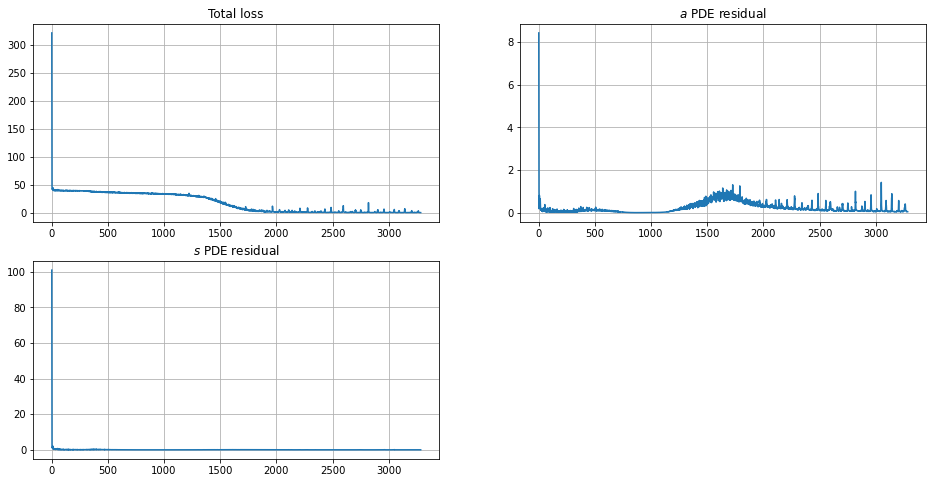

In [5]:
start = 0
end = len(loss)
_ = plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.plot(loss[start:end])
#plt.yscale('log')
plt.title(r"Total loss")
plt.grid()

plt.subplot(2,2,2)
plt.plot(loss_a[start:end])
#plt.yscale('log')
plt.title(r"$a$ PDE residual")
plt.grid()


plt.subplot(2,2,3)
plt.plot(loss_s[start:end])
#plt.yscale('log')
plt.title(r"$s$ PDE residual")
plt.grid()


plt.show()



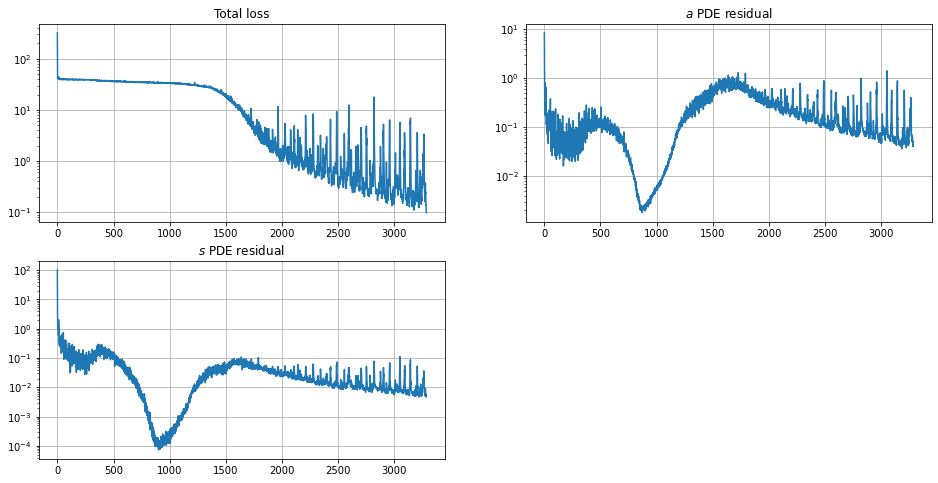

In [6]:
start = 0
end = len(loss)
_ = plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.plot(loss[start:end])
plt.yscale('log')
plt.title(r"Total loss")
plt.grid()

plt.subplot(2,2,2)
plt.plot(loss_a[start:end])
plt.yscale('log')
plt.title(r"$a$ PDE residual")
plt.grid()


plt.subplot(2,2,3)
plt.plot(loss_s[start:end])
plt.yscale('log')
plt.title(r"$s$ PDE residual")
plt.grid()


plt.show()



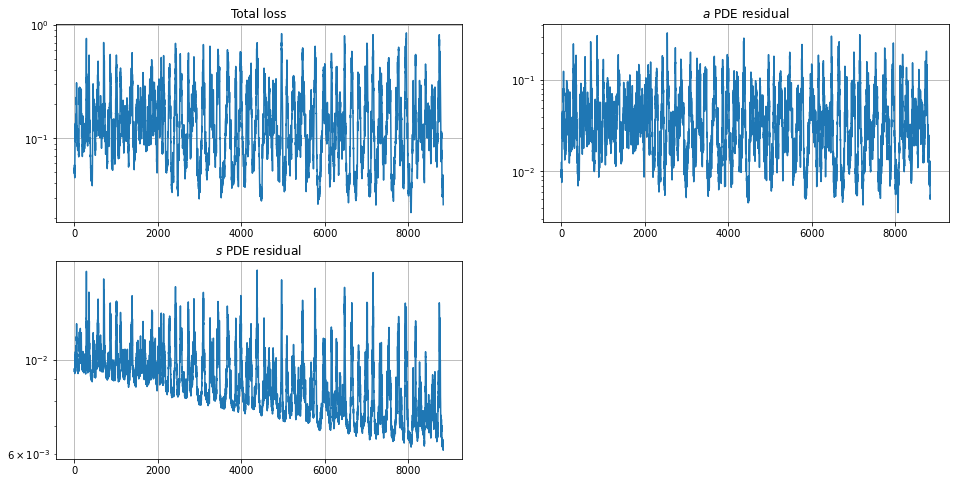

In [19]:
start = 0
end = len(loss)
_ = plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
plt.plot(loss2[start:end])
plt.yscale('log')
plt.title(r"Total loss")
plt.grid()

plt.subplot(2,2,2)
plt.plot(loss_a2[start:end])
plt.yscale('log')
plt.title(r"$a$ PDE residual")
plt.grid()


plt.subplot(2,2,3)
plt.plot(loss_s2[start:end])
plt.yscale('log')
plt.title(r"$s$ PDE residual")
plt.grid()


plt.show()


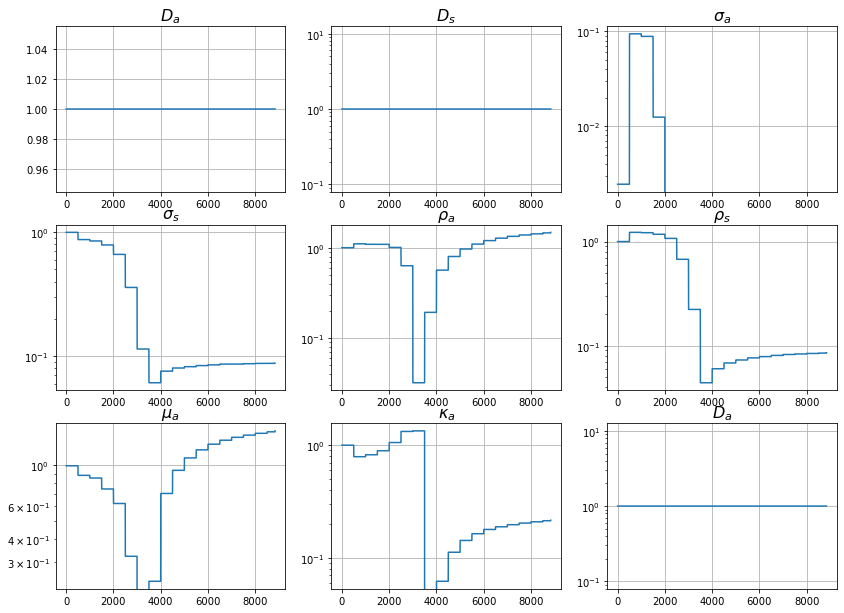

In [7]:
start = 0
end = -1
_ = plt.figure(figsize=(14,14))

plt.subplot(4,3,1)
plt.plot(np.r_[params_estimates['D_a']])
plt.title(r"$D_a$", fontsize=16)
#plt.yscale('log')
plt.grid()

plt.subplot(4,3,2)
plt.plot(np.r_[params_estimates['D_s']])
plt.title(r"$D_s$", fontsize=16)
plt.yscale('log')
plt.grid()


plt.subplot(4,3,3)
plt.plot(np.r_[params_estimates['sigma_a']])
plt.title(r"$\sigma_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.subplot(4,3,4)
plt.plot(np.r_[params_estimates['sigma_s']])
plt.title(r"$\sigma_s$", fontsize=16)
plt.yscale('log')
#plt.ylim([0.005,.04])
plt.grid()

plt.subplot(4,3,5)
plt.plot(np.r_[params_estimates['rho_a']])
plt.title(r"$\rho_a$", fontsize=16)
plt.yscale('log')
plt.grid()


plt.subplot(4,3,6)
plt.plot(np.r_[params_estimates['rho_s']])
plt.title(r"$\rho_s$", fontsize=16)
plt.yscale('log')
#plt.ylim([0.0,.05])
plt.grid()


plt.subplot(4,3,7)
plt.plot(np.r_[params_estimates['mu_a']])
plt.title(r"$\mu_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.subplot(4,3,8)
plt.plot(np.r_[params_estimates['kappa_a']])
plt.title(r"$\kappa_a$", fontsize=16)
plt.yscale('log')
#plt.ylim([0,1])
plt.grid()

plt.subplot(4,3,9)
plt.plot(np.r_[params_estimates['D_a']])
plt.title(r"$D_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.show()

In [14]:
def print_vals(name, value, actual=None):
    def _get_val(item):
        val = item.tolist()
        if type(val) is float:
            return val
        else:
            return val[0]
    value = _get_val(value)
    
    if actual is not None and actual > 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/(actual):0.8f}")
    elif actual is not None and actual == 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f} ")
        
    else:
        print(f"{name}: {value:0.8f}")
    

D_a = model.sess.run(model.D_a)
D_s = model.sess.run(model.D_s)
sigma_s = model.sess.run(model.sigma_s)
rho_s = model.sess.run(model.rho_s)

sigma_a = model.sess.run(model.sigma_a)
rho_a = model.sess.run(model.rho_a)
mu_a = model.sess.run(model.mu_a)
kappa_a = model.sess.run(model.kappa_a)


print_vals("D_s", D_s, 0.2)
print_vals("sigma_s", sigma_s, 0.02)
print_vals("rho_s", rho_s, 0.02)
print()
print_vals("D_a", D_s, 0.005)
print_vals("sigma_a", sigma_a, 0.0)
print_vals("rho_a", rho_a,0.01)
print_vals("mu_a", mu_a, 0.01 )
print_vals("kappa_a", kappa_a, 0.25)

D_s: 1.00000000, actual: 0.200, difference: 0.80000000, relative: %400.00000000
sigma_s: 0.09082009, actual: 0.020, difference: 0.07082009, relative: %354.10044491
rho_s: 0.09074217, actual: 0.020, difference: 0.07074217, relative: %353.71085405

D_a: 1.00000000, actual: 0.005, difference: 0.99500000, relative: %19900.00000000
sigma_a: 0.00000000, actual: 0.000, difference: 0.00000000 
rho_a: 1.75890505, actual: 0.010, difference: 1.74890505, relative: %17489.05053139
mu_a: 1.77396703, actual: 0.010, difference: 1.76396703, relative: %17639.67027664
kappa_a: 0.24201126, actual: 0.250, difference: 0.00798874, relative: %3.19549441


# Estimated parameters

In [133]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
#XX_2 = X_2.flatten()# N 
#YY_2 = Y_2.flatten()# N 
T_2 = T#1#T
XX_2 = np.tile(X_2.flatten(), T_2) # N x T
YY_2 = np.tile(Y_2.flatten(), T_2) # N x T

#index = -3
t_test = t_star[-T:]#[50000]#t_star[-T:]#t_star[index]#0#5000000

TT_2 = np.repeat(t_test, N) # T x N

#TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [134]:
t_2.shape

(32768, 1)

In [135]:
t_test

array([46966.73189824, 47064.57925636, 47162.42661448, 47260.2739726 ,
       47358.12133072, 47455.96868885, 47553.81604697, 47651.66340509,
       47749.51076321, 47847.35812133, 47945.20547945, 48043.05283757,
       48140.90019569, 48238.74755382, 48336.59491194, 48434.44227006,
       48532.28962818, 48630.1369863 , 48727.98434442, 48825.83170254,
       48923.67906067, 49021.52641879, 49119.37377691, 49217.22113503,
       49315.06849315, 49412.91585127, 49510.76320939, 49608.61056751,
       49706.45792564, 49804.30528376, 49902.15264188, 50000.        ])

In [136]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
#a_2 = a_2.reshape((x_size,y_size))
#s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:a_train,
           model.s_tf:s_train}
l_a_2 = model.sess.run(model.loss_a, tf_dict)
l_s_2 = model.sess.run(model.loss_s, tf_dict)
l_2 = model.sess.run(model.loss, tf_dict)

print( f"Loss_a : {l_a_2:.8f}")
print( f"Loss_s : {l_s_2:.8f}")
print( f"Loss   : {l_2:.8f}")
print( f"Loss Diff  : {l_2-l_a_2-l_s_2:.8f}")

Loss_a : 0.00000040
Loss_s : 0.00000159
Loss   : 9.95555687
Loss Diff  : 9.95555496


In [137]:
print(np.sum(np.power(a_2 - a_train,2)))
print(np.sum(np.power(s_2 - s_train,2)))
print(np.sum(np.power(a_2 - a_train,2)) +
      np.sum(np.power(s_2 - s_train,2)))

8.502239075754737
1.4533152356548327
9.95555431140957


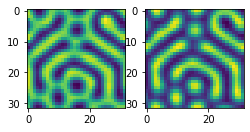

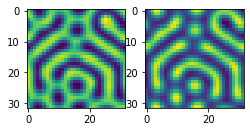

In [138]:
start = 0
plt.subplot(131)
plt.imshow(a_2[(start*N):((start+1)*N), :].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(s_2[(start*N):((start+1)*N), :].reshape((x_size,y_size)))
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, -1].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, -1].reshape((x_size,y_size)))
plt.show()



In [59]:
T

32

In [96]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = 500#-1
t_test = 25000#t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [97]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_tf:data[1, :, :, index].flatten()[:, np.newaxis]}
print( f"Loss_a : {model.sess.run(model.loss_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 0.00000008
Loss_s : 0.00005015
Loss   : 48.38435745


In [98]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

44.568421832960176
3.815885208497169


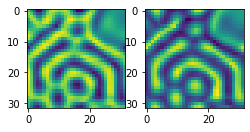

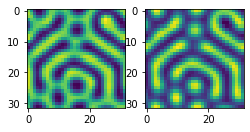

In [99]:

plt.subplot(131)
plt.imshow(a_2)
plt.subplot(132)
plt.imshow(s_2)
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.show()

In [363]:
saver = tf.train.Saver()
saver.save(model.sess, './PINN_Turring_model_loss_full_32_steps', global_step=0)

'./PINN_Turring_model_loss_full_32_steps-0'

In [364]:
print(model.x_tf.name)
print(model.y_tf.name)
print(model.t_tf.name)
print(model.a_pred.name)
print(model.s_pred.name)
print(model.loss_1.name)
print(model.loss_a.name)
print(model.loss_s.name)

x_tf_19:0
y_tf_19:0
t_tf_19:0
a_pred_19:0
s_pred_19:0
add_253:0
loss_a_19:0
loss_s_19:0
